# Episode 5: Statistical Analysis
## 5.1. ROI driven analysis with Nilearn
## 5.1.1. Volumetric Atlases

In [1]:
import os
import numpy   as np
import nibabel as nib
import nilearn
import nipype
import matplotlib.pyplot as plt

from nilearn import plotting
tutorial_root = os.getcwd()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/dicom/__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)


### 5.1.1.1. Visualizing anatomical atlases
### 🧠 Cortical atlas parcellations
Brain atlases are used for identifying regions of interest, often required to obtain statistical inferences in neuroimaging. Parcellation of such units in the cortex is achieved using cortical atlases. The use of a few commonly used cortical atlases is demonstrated in this section.

In [2]:
from nilearn import datasets

### ▪️ Visualizing the Automated Anatomical Labeling (AAL)  atlas
The AAL atlaswidely used for cortical parcellation. Related citations: <a href="https://pubmed.ncbi.nlm.nih.gov/11771995/" target="_blank">*Tzourio-Mazoyer 2002*</a>. \
Updated versions, AAL2 and AAL3, has been released in 2015 and 2019 respectively. (Related information can be found on <a href="https://www.gin.cnrs.fr/en/tools/aal/" target="_blank">this page</a>.).

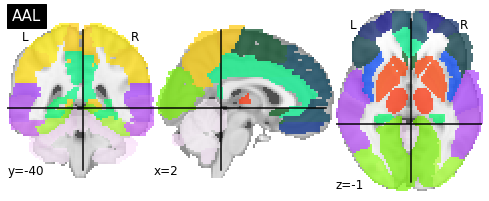

In [3]:
dataset = datasets.fetch_atlas_aal('SPM12')
atlas_filename = dataset.maps
plotting.plot_roi(atlas_filename, title="AAL")

### ▪️ Visualizing Yeo 2011 functional parcellations (Yeo 2011)
Atlas based on 1000 subjects exhibiting co-activations of the brain. Two versions are available that include 7 vs. 17 neworks. There are 7 labels in the original Yeo atlas, that is indicated in the colorbar. These 7 labels correspond to networks that comprise several regions. \
Related citations: <a href="https://journals.physiology.org/doi/full/10.1152/jn.00338.2011" target="_blank">*Yeo 2011*</a>.

In [4]:
#dataset   = datasets.fetch_atlas_yeo_2011()
#atlas_yeo = dataset.thick_7
#plotting.plot_roi(atlas_yeo, title="Yeo 2011")

### ▪️ Visualizing the Local-Global Parcellation of the Human Cerebral Cortex (Schaefer 2018)
These novel parcellations add further refinement by subparcellating the global networks based on a local gradient approach, based on the work by Thomas Yeo, 2011 (visualized above). Parcellations come in several versions, breaking down the cortex into up to 1000 regions.

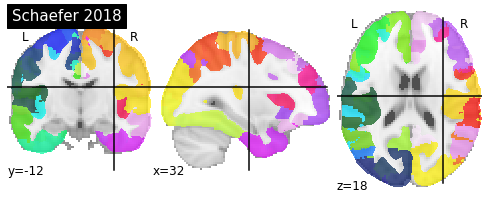

In [5]:
dataset = datasets.fetch_atlas_schaefer_2018()
atlas_filename = dataset.maps
plotting.plot_roi(atlas_filename, title="Schaefer 2018")

# By default, the number of ROIs is 400 and  and ROI annotations according neo networks is 7.
# This may be changed by changing the inputs to the function as below.
# nilearn.datasets.fetch_atlas_schaefer_2018(n_rois=400, yeo_networks=7)

### ▪️ Visualizing the Harvard-Oxford atlas

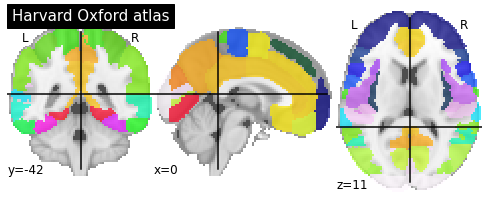

In [6]:
dataset = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr25-2mm')
atlas_filename = dataset.maps
plotting.plot_roi(atlas_filename, title="Harvard Oxford atlas")

### 🧠 Subcortical atlas parcellations

### ▪️ Visualizing CIT168 Reinforcement Learning Atlas
This atlas is often used in work that study brain structures involved in reinforcement learning processes.\
Related citations: <a href="https://www.nature.com/articles/sdata201863" target="_blank">*Pauli 2017*</a>. 

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/ma/core.py:2795: UserWarning: Warning: converting a masked element to nan.
  order=order, subok=True, ndmin=ndmin)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/nilearn/plotting/displays.py:99: UserWarning: No contour levels were found within the data range.
  **kwargs)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/nilearn/plotting/displays.py:99: UserWarning: linewidths is ignored by contourf
  **kwargs)


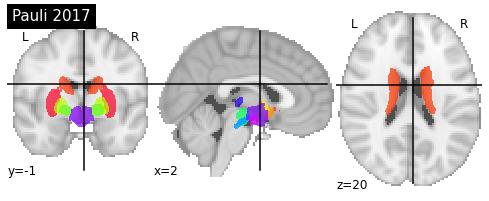

In [7]:
dataset = datasets.fetch_atlas_pauli_2017()
atlas_filename = dataset.maps 
plotting.plot_prob_atlas(atlas_filename, title="Pauli 2017")

### 5.1.1.2. Regional volumetric analysis

Structural properties or anatomical characteristics of ROIs can be used to further our understanding on underlying abnormalities. For this, ROIs are segmented using suitable software for ROI analysis. 
In this case, we consider segmentation of a single image using FreeSurfer and FSL, two commonly used software.

### ▪️ Using FSL to segment a region of interest

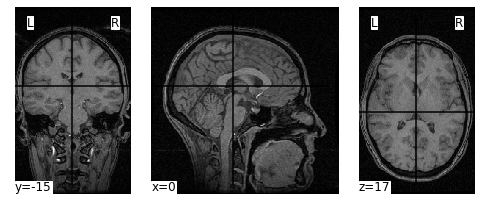

In [8]:
import shutil

# Anatomical image from the haxby_dataset is loaded
# It is then saved to the current working directory
haxby_dataset = datasets.fetch_haxby()
anat_file     = haxby_dataset.anat[0]

# Make a new directory for FSL segmentation is not available
# Go to new directory - working direcotry
if not os.path.isdir('FSLseg'):
    os.mkdir('FSLseg')

os.chdir(os.path.join(os.getcwd(),'FSLseg'))
shutil.copyfile(anat_file,os.path.join(os.getcwd(),'structural.nii.gz'))

# We can then use the .nii.gz we will be processing
plotting.plot_img(anat_file,cmap='gray')

In [9]:
from nipype.interfaces import fsl
import itk

#run FSL first to segment the reguired segmentations
#For now we only focus on the left hippocampus
first = fsl.FIRST()
first.inputs.in_file  = 'structural.nii.gz'
first.inputs.out_file = 'segmented.nii.gz'

# Can be removed or commented if all regions need to be segmented
first.inputs.list_of_specific_structures=['L_Hipp'] 

res = first.run()

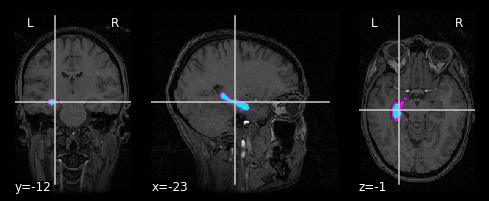

In [10]:
# Load T1w image and segmented labels
# Then overlay and view output
T1w_img   = nib.load('structural.nii.gz')
seg_labels= nib.load('segmented-L_Hipp_first.nii.gz')

plotting.plot_roi(roi_img=seg_labels, bg_img=T1w_img, alpha=0.9, cmap="cool",dim=-.5);

In [11]:
import nibabel.imagestats as imagestats
# Volume of the Left hippocampus
imagestats.mask_volume(nib.Nifti1Image(seg_labels.get_fdata(), np.eye(4)))

4189.0

### ▪️ Using FreeSurfer for volumetric Analysis
Freesurfer ReconAll can be used to get all segmentations and stats. Can be achieved using steps given in the nipype beginner tutorial.
This takes a considerably long time to execute. Therefore, the directory is made available in _ _extras/5_OtherFiles/sub001_ReconAll.tar.gz_ in the repository.

In [12]:
# Make a new directory for FSL segmentation is not available
# Go to new directory - working direcotry
# Provided freesurfer outputs for sub001 extracted to new working directory

from subprocess import check_output

if not os.path.isdir('FSseg') and not os.path.basename(os.getcwd())=='FSseg':
    os.mkdir('FSseg')

os.chdir(os.path.join(tutorial_root,'FSseg'))

In [25]:
#Download github directory

In [13]:
#aseg_stats=os.path.join('/Users/swapna/DataCarpentry_sMRI/FSseg/sub001/stats/aseg.stats')
aseg_stats_path=os.path.join(os.getcwd(),'sub001/stats/aseg.stats')
aseg_stats     = np.loadtxt(aseg_stats_path, dtype="i1,i1,i4,f4,S32,f4,f4,f4,f4,f4")
aseg_stats

array([( 1,  4,  8744, 9.09630e+03, b'Left-Lateral-Ventricle',  20.6608, 13.8154,  0.,  84.,  84.),
       ( 2,  5,   518, 5.52900e+02, b'Left-Inf-Lat-Vent',  34.8359, 16.1599,  0.,  83.,  83.),
       ( 3,  7, 13969, 1.48399e+04, b'Left-Cerebellum-White-Matter',  81.6983,  8.4093, 13., 106.,  93.),
       ( 4,  8, 55942, 5.59028e+04, b'Left-Cerebellum-Cortex',  52.5322, 12.5234,  0., 130., 130.),
       ( 5, 10,  8452, 8.15100e+03, b'Left-Thalamus-Proper',  83.3055, 10.4368, 22., 109.,  87.),
       ( 6, 11,  4308, 4.34240e+03, b'Left-Caudate',  71.5796,  7.8064, 38.,  99.,  61.),
       ( 7, 12,  5426, 5.42390e+03, b'Left-Putamen',  80.4724,  6.3367, 48., 106.,  58.),
       ( 8, 13,  2156, 2.10520e+03, b'Left-Pallidum',  95.1702,  5.3659, 71., 111.,  40.),
       ( 9, 14,  1137, 1.19050e+03, b'3rd-Ventricle',  28.4362, 15.0361,  2.,  78.,  76.),
       (10, 15,  3585, 3.72130e+03, b'4th-Ventricle',  14.128 , 10.0585,  0.,  65.,  65.),
       (11, 16, 19987, 2.01286e+04, b'Brain-Stem

#### Volumetric Analysis: ROI differences in Young, Middle Aged, Nondemented and Demented Older Adults

The summarized freesurfer outputs from the OASIS1 dataset from the _extras/5_OtherFiles/OASIS_FS_ASEG. Older adults who are demented at the time of scanning and those who are progressing have been given a Clinical Dementia Rating (CDR).

We can observe the ROI volumetric differences in adults and how these volumes vary based on their CDR. For this example, we consider 6 regions of interest: Left/Right Amygdala, Hippocampus and Lateral ventricle.

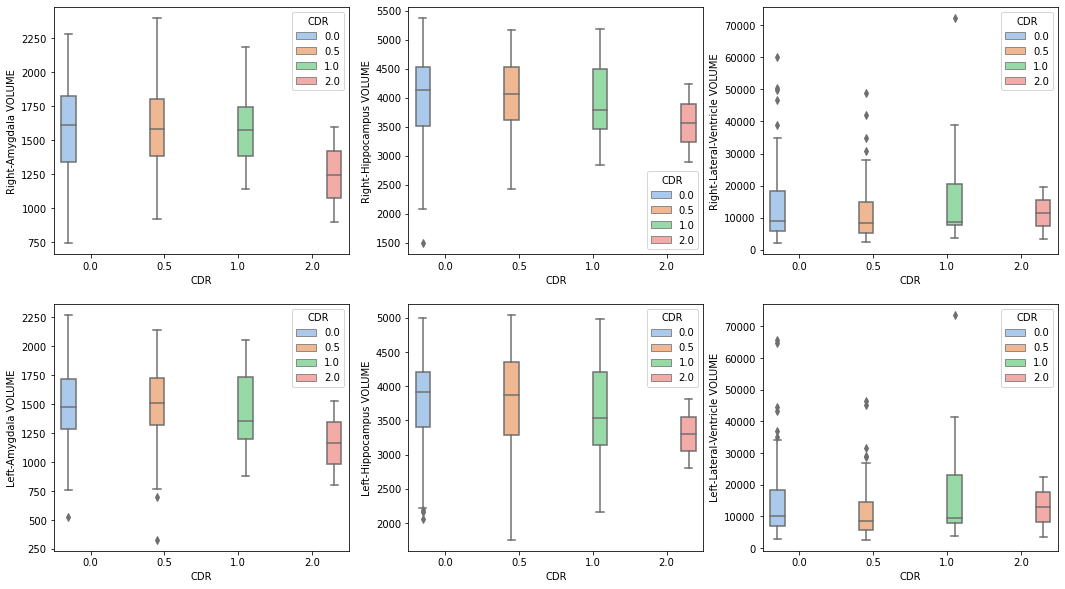

In [14]:
import pandas as pd
import seaborn as sns
oasis_aseg = pd.read_csv("/Users/swapna/DataCarpentry_sMRI/OASIS_FS_ASEG.CSV")

#Set current working directory to where you downloaded the .csv files
os.chdir(tutorial_root)

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
sns.boxplot(ax=axes[0, 0], data=oasis_aseg, x='CDR', y='Right-Amygdala VOLUME',hue='CDR',palette='pastel')
sns.boxplot(ax=axes[0, 1], data=oasis_aseg, x='CDR', y='Right-Hippocampus VOLUME',hue='CDR',palette='pastel')
sns.boxplot(ax=axes[0, 2], data=oasis_aseg, x='CDR', y='Right-Lateral-Ventricle VOLUME',hue='CDR',palette='pastel')

sns.boxplot(ax=axes[1, 0], data=oasis_aseg, x='CDR', y='Left-Amygdala VOLUME',hue='CDR',palette='pastel')
sns.boxplot(ax=axes[1, 1], data=oasis_aseg, x='CDR', y='Left-Hippocampus VOLUME',hue='CDR',palette='pastel')
sns.boxplot(ax=axes[1, 2], data=oasis_aseg, x='CDR', y='Left-Lateral-Ventricle VOLUME',hue='CDR',palette='pastel')

#### Cohen's D effect size for selected ROIs in adults over 60 years of age
For simplicity, an updated .csv file has been uploaded separately. In this those who have a CDR score>0 was considered to be demented or progressing towards dementia.
The effect size is calculated between two groups: healthy adults and those who show signs of AD.

In [15]:
oasis_aseg_60 = pd.read_csv("/Users/swapna/DataCarpentry_sMRI/OASIS_FS_ASEG_OVER60new.CSV")

See Exercise 5.2. The resulting output was as shown below.

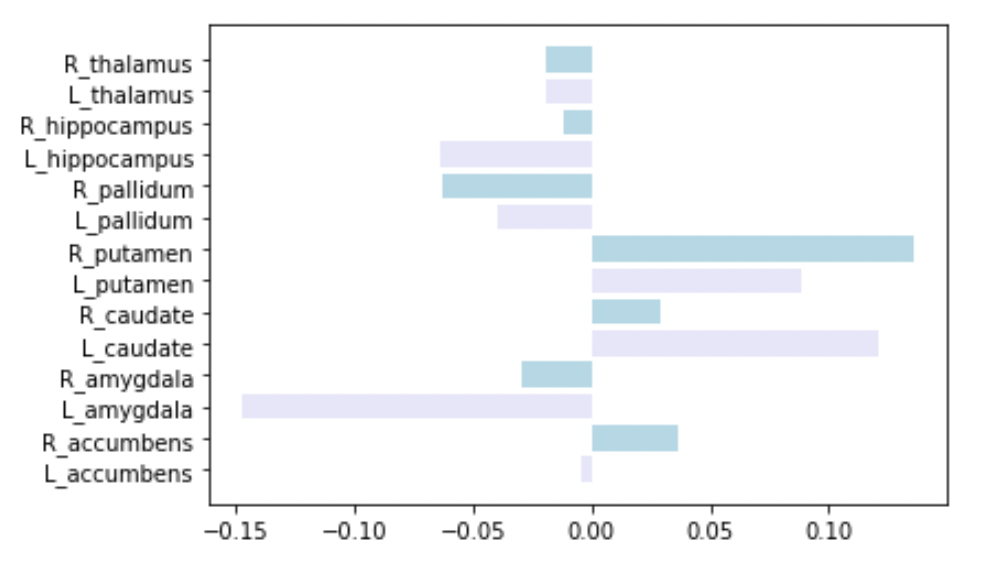

In [16]:
from IPython import display
display.Image("/Users/swapna/Desktop/Visualization/5_EffectSize.png", width = 450, height = 225)

## 5.1.2. Cortical surface parcellations
### 5.1.2.1. Visualizing cortical surface parcellations
### 🧠 Cortical surface parcellations

### ▪️ Visualizing the Destrieux atlas
A parcellation scheme widely used in the freesurfer world based on sulcal depth and yielding precise automated definition of cortical gyri and sulci. \ 
Related citations: Related citations: <a href="https://www.sciencedirect.com/science/article/abs/pii/S1053811910008542?via%3Dihub" target="_blank">*Destrieux 2010*</a>. 

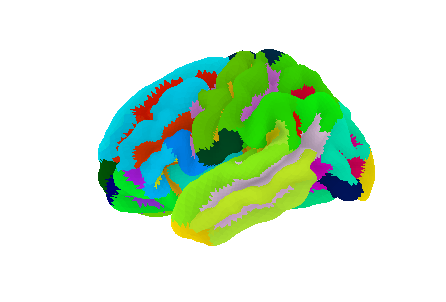

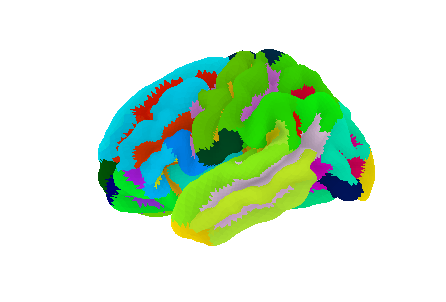

In [17]:
destrieux_atlas = datasets.fetch_atlas_surf_destrieux()
parcellation = destrieux_atlas['map_left']

# Retrieve fsaverage5 surface dataset for the plotting background. It contains
# the surface template as pial and inflated version and a sulcal depth maps which is used for shading
fsaverage = datasets.fetch_surf_fsaverage()

# Lateral view is observed in this example.
# Other views (e.g. posterior, ventral may also be used)
plotting.plot_surf_roi(fsaverage['pial_left'], roi_map=parcellation,hemi='left', 
                       view='lateral',bg_map=fsaverage['sulc_left'], bg_on_data=True,darkness=.5)